# Perform a two-sided KS-test using the DMSO or no treatment heart #7 (healthy) cells to assess how different each feature is based on the two populations

## Import libraries

In [1]:
import pathlib
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pycytominer.cyto_utils import infer_cp_features

## Define KS-test function to generate dataframe

In [2]:
def perform_ks_test(
    df1: pd.DataFrame, df2: pd.DataFrame, cp_features: list[str]
) -> pd.DataFrame:
    """Perform and return a data frame with the KS-test results per CellProfiler feature.

    Args:
        df1 (pd.DataFrame): First data frame in the ks-test (will be represented by positive values if greater distribution)
        df2 (pd.DataFrame): Second data frame in the ks-test (will be represented by negative values if greater distribution)
        cp_features (list[str]): List of strings with the names of the CellProfiler features to perform the ks-test on

    Returns:
        pd.DataFrame: Data frame containing ks-test results
    """
    ks_results = []
    for feature in cp_features:
        result = stats.ks_2samp(df1[feature], df2[feature])
        ks_statistic = result.statistic
        p_value = result.pvalue
        statistic_location = result.statistic_location
        statistic_sign = result.statistic_sign

        ks_test_result = ks_statistic * statistic_sign

        ks_results.append(
            {
                "Feature": feature,
                "KS Statistic": ks_statistic,
                "P-Value": p_value,
                "Direction": statistic_sign,
                "Stat Location": statistic_location,
                "KS_test_result": ks_test_result,
            }
        )

    ks_results_df = pd.DataFrame(ks_results)
    ks_results_df["-log10pval"] = -np.log10(ks_results_df["P-Value"])
    ks_results_df["Compartment"] = ks_results_df["Feature"].str.split("_").str[0]
    ks_results_df["Measurement"] = ks_results_df["Feature"].str.split("_").str[1]

    return ks_results_df

## Read in plate 4 feature selected parquet file

In [3]:
# Set up output directory for figures
figures_dir = pathlib.Path("./figures")
figures_dir.mkdir(parents=True, exist_ok=True)

# Load in plate 4 data
plate4_df = pd.read_parquet(
    pathlib.Path(
        "../../../3.process_cfret_features/data/single_cell_profiles/localhost231120090001_sc_feature_selected.parquet"
    )
)

# Fill NaN values in the "Metadata_treatment" column with "None"
plate4_df['Metadata_treatment'] = plate4_df['Metadata_treatment'].fillna("None")

# Get columns that are cp_features (will be the same for shuffled)
cp_features = infer_cp_features(plate4_df)

print(plate4_df.shape)
plate4_df.head()

(16860, 644)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,2,Healthy,None,None,787.816143,113.743274,832.342493,109.226914,...,0.677309,-0.461174,-0.479672,-0.329932,-0.864552,-0.838569,-0.127637,-0.252706,-0.132274,-0.157145
1,B,2,2,Healthy,None,None,612.015315,258.122523,583.551435,220.881555,...,-0.564138,0.403113,0.371748,0.403600,0.186117,0.516979,-0.224873,-0.306135,-0.231927,-0.162190
2,B,2,2,Healthy,None,None,54.977129,271.567823,69.468928,289.697152,...,1.575570,0.011678,0.368805,0.442829,0.658614,-0.956635,-0.654911,-0.322824,-0.249662,2.336911
3,B,2,2,Healthy,None,None,199.395062,268.792593,193.914743,269.641581,...,-1.108619,0.689609,0.695857,0.535811,0.878447,0.687421,0.963423,-0.332691,-0.247825,-0.341341
4,B,2,2,Healthy,None,None,531.072041,276.144082,524.886555,279.036043,...,-2.759326,0.706931,0.885813,0.575168,0.521390,1.579863,1.387026,-0.328504,-0.256229,-0.371318


## Shuffle the plate 4 data to get a randomized data frame to compare to the non-shuffled results

In [4]:
# Separate features from metadata
metadata_columns = [col for col in plate4_df.columns if col.startswith('Metadata')]
feature_columns = [col for col in plate4_df.columns if col not in metadata_columns]

# Generate dataframes with respective columns
metadata_df = plate4_df[metadata_columns]
feature_df = plate4_df[feature_columns]

# Set a random state
random_state = 0

# Convert feature_df to numpy array and shuffle
feature_array = feature_df.values
for column in feature_array.T:
    np.random.seed(random_state)
    np.random.shuffle(column)

# Combine shuffled features with metadata
shuffled_feature_df = pd.DataFrame(feature_array, columns=feature_columns)
shuffled_plate4_df = pd.concat([metadata_df, shuffled_feature_df], axis=1)

print(shuffled_plate4_df.shape)
shuffled_plate4_df.head()

(16860, 644)


,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,...,Nuclei_Texture_InfoMeas2_PM_3_03_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_01_256,Nuclei_Texture_InverseDifferenceMoment_ER_3_03_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_00_256,Nuclei_Texture_InverseDifferenceMoment_Mitochondria_3_02_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_01_256,Nuclei_Texture_InverseDifferenceMoment_PM_3_03_256,Nuclei_Texture_SumVariance_ER_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_PM_3_01_256
0,B,2,2,Healthy,None,None,787.816143,113.743274,832.342493,109.226914,...,-1.380781,0.201199,-0.351733,-0.009756,0.423627,1.431049,0.732796,-0.226962,-0.206277,-0.318013
1,B,2,2,Healthy,None,None,612.015315,258.122523,583.551435,220.881555,...,1.015955,-0.587114,-0.540074,0.920376,0.642175,0.052832,0.475960,0.022453,-0.242220,-0.223764
2,B,2,2,Healthy,None,None,54.977129,271.567823,69.468928,289.697152,...,0.824820,-1.380671,-1.987968,-0.229165,-0.576767,-1.122481,-1.310030,0.201258,-0.117935,0.000645
3,B,2,2,Healthy,None,None,199.395062,268.792593,193.914743,269.641581,...,-1.831712,1.060397,0.997409,1.348783,1.418485,1.488627,1.533442,-0.346819,-0.263632,-0.378091
4,B,2,2,Healthy,None,None,531.072041,276.144082,524.886555,279.036043,...,-0.041624,-1.516386,-1.414452,-1.309272,-0.122053,-0.648164,-0.464471,0.436139,-0.144750,-0.198090


## Split shuffled and non-shuffled data based on treatment for heart #7 only

In [5]:
# Subset the data for heart #7 with DMSO treatment
heart_7_DMSO = plate4_df[(plate4_df['Metadata_treatment'] == 'DMSO') & (plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with no treatment
heart_7_None = plate4_df[(plate4_df['Metadata_treatment'] == 'None') & (plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with DMSO treatment (shuffled)
shuffled_heart_7_DMSO = shuffled_plate4_df[(shuffled_plate4_df['Metadata_treatment'] == 'DMSO') & (shuffled_plate4_df['Metadata_heart_number'] == 7)]

# Subset the data for heart #7 with no treatment (shuffled)
shuffled_heart_7_None = shuffled_plate4_df[(shuffled_plate4_df['Metadata_treatment'] == 'None') & (shuffled_plate4_df['Metadata_heart_number'] == 7)]

print("Number of cells for heart #7 DMSO treatment:", heart_7_DMSO.shape[0])
print("Number of cells for heart #7 no treatment:", heart_7_None.shape[0])

Number of cells for heart #7 DMSO treatment: 939
Number of cells for heart #7 no treatment: 2819


## Perform KS-test for non-shuffled data

In [6]:
ks_results_df = perform_ks_test(heart_7_DMSO, heart_7_None, cp_features)

print(ks_results_df.shape)
ks_results_df.head()

(625, 9)


,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
0,Cytoplasm_AreaShape_BoundingBoxArea,0.098248,2.279371e-06,-1,-0.098575,-0.098248,5.642185,Cytoplasm,AreaShape
1,Cytoplasm_AreaShape_Compactness,0.105820,2.468228e-07,1,-0.028261,0.105820,6.607615,Cytoplasm,AreaShape
2,Cytoplasm_AreaShape_Eccentricity,0.054547,2.891997e-02,-1,0.548396,-0.054547,1.538802,Cytoplasm,AreaShape
3,Cytoplasm_AreaShape_Extent,0.037101,2.781299e-01,-1,-0.840676,-0.037101,0.555752,Cytoplasm,AreaShape
4,Cytoplasm_AreaShape_FormFactor,0.105820,2.468228e-07,-1,-0.510611,-0.105820,6.607615,Cytoplasm,AreaShape


## Perform KS-test for shuffled data

In [7]:
shuffled_ks_results_df = perform_ks_test(shuffled_heart_7_DMSO, shuffled_heart_7_None, cp_features)

print(shuffled_ks_results_df.shape)
shuffled_ks_results_df.head()

(625, 9)


,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
0,Cytoplasm_AreaShape_BoundingBoxArea,0.029300,0.567966,-1,0.320868,-0.029300,0.245678,Cytoplasm,AreaShape
1,Cytoplasm_AreaShape_Compactness,0.025675,0.729774,-1,1.172878,-0.025675,0.136812,Cytoplasm,AreaShape
2,Cytoplasm_AreaShape_Eccentricity,0.022043,0.874277,-1,1.019932,-0.022043,0.058351,Cytoplasm,AreaShape
3,Cytoplasm_AreaShape_Extent,0.024566,0.777589,1,-1.364781,0.024566,0.109250,Cytoplasm,AreaShape
4,Cytoplasm_AreaShape_FormFactor,0.025675,0.729774,1,-1.200221,0.025675,0.136812,Cytoplasm,AreaShape


Note: Positive values if the empirical distribution function of **DMSO** exceeds the empirical distribution function of **no treatment** at statistic_location, otherwise negative.

## Generate volcano plot visualizations for each dataset

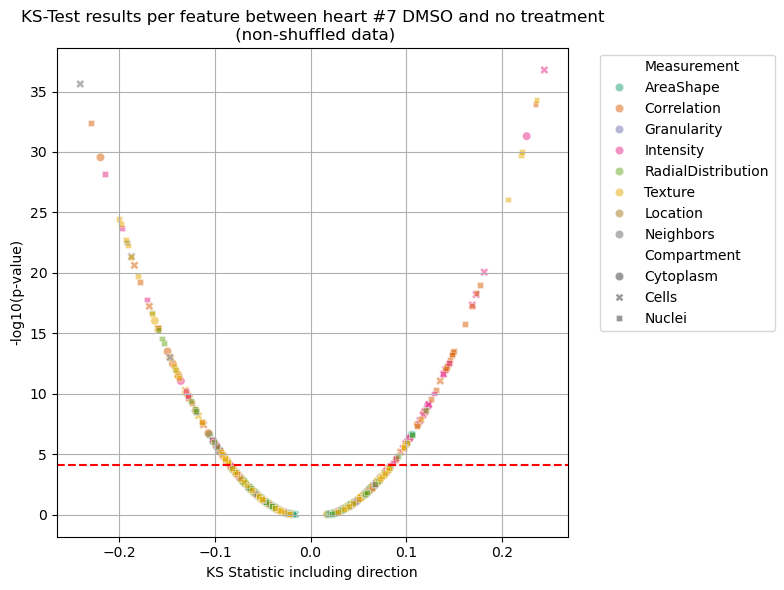

In [8]:
# Plot the volcano plot using Seaborn with legend
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ks_results_df, x='KS_test_result', y='-log10pval', hue='Measurement', style='Compartment', palette='Dark2', alpha=0.5)
plt.title('KS-Test results per feature between heart #7 DMSO and no treatment\n (non-shuffled data)')
plt.xlabel('KS Statistic including direction')
plt.ylabel('-log10(p-value)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add a horizontal line for p-value threshold of 0. divided by the number of features
plt.axhline(y=-np.log10(0.05 / ks_results_df.shape[0]), color='red', linestyle='--')

plt.tight_layout()
plt.savefig(f"{figures_dir}/ks_test_healthy_dmso_none.png", dpi=500)

plt.show()

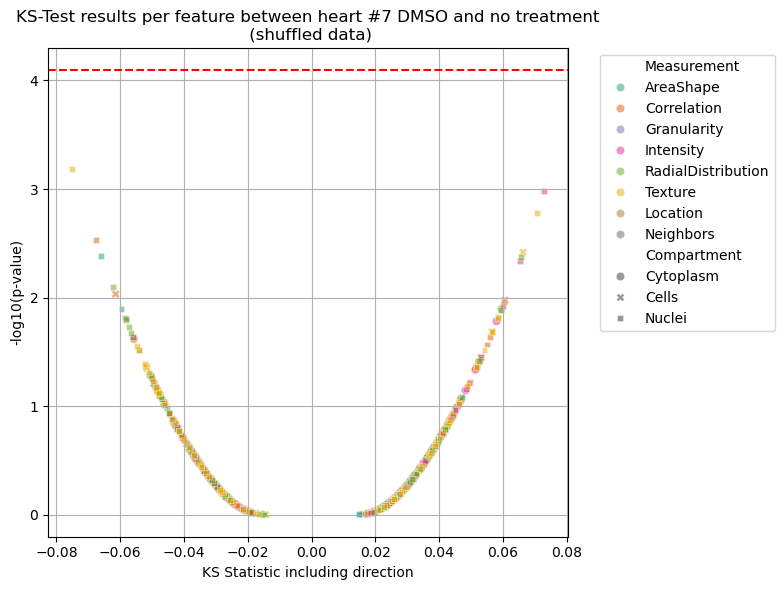

In [9]:
# Plot the volcano plot using Seaborn with legend
plt.figure(figsize=(8, 6))
sns.scatterplot(data=shuffled_ks_results_df, x='KS_test_result', y='-log10pval', hue='Measurement', style='Compartment', palette='Dark2', alpha=0.5)
plt.title('KS-Test results per feature between heart #7 DMSO and no treatment\n (shuffled data)')
plt.xlabel('KS Statistic including direction')
plt.ylabel('-log10(p-value)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Add a horizontal line for p-value threshold of 0. divided by the number of features
plt.axhline(y=-np.log10(0.05 / shuffled_ks_results_df.shape[0]), color='red', linestyle='--')

plt.tight_layout()
plt.savefig(f"{figures_dir}/ks_test_healthy_dmso_none_shuffled.png", dpi=500)

plt.show()

## Go over the non-shuffled data to assess top differential features

In [10]:
# Print the sorted dataframe to see the top features in both directions
sorted_df = ks_results_df.sort_values(by="KS_test_result", ascending=False)

sorted_df

,Feature,KS Statistic,P-Value,Direction,Stat Location,KS_test_result,-log10pval,Compartment,Measurement
286,Cells_Intensity_MinIntensityEdge_Actin,0.244532,1.641785e-37,1,-0.127701,0.244532,36.784684,Cells,Intensity
561,Nuclei_Texture_AngularSecondMoment_PM_3_01_256,0.236360,4.853492e-35,1,0.102844,0.236360,34.313946,Nuclei,Texture
437,Nuclei_Correlation_K_PM_Actin,0.235233,1.146984e-34,1,-0.227342,0.235233,33.940443,Nuclei,Correlation
63,Cytoplasm_Intensity_LowerQuartileIntensity_Actin,0.226044,4.919505e-32,1,-0.204623,0.226044,31.308079,Cytoplasm,Intensity
621,Nuclei_Texture_InverseDifferenceMoment_PM_3_03...,0.221374,1.011425e-30,1,0.130945,0.221374,29.995066,Nuclei,Texture
...,...,...,...,...,...,...,...,...,...
568,Nuclei_Texture_Contrast_PM_3_01_256,0.200141,3.642439e-25,-1,-0.344522,-0.200141,24.438608,Nuclei,Texture
487,Nuclei_Intensity_MADIntensity_PM,0.214670,6.694656e-29,-1,-0.366722,-0.214670,28.174272,Nuclei,Intensity
34,Cytoplasm_Correlation_Correlation_ER_PM,0.219676,2.767178e-30,-1,-0.030867,-0.219676,29.557963,Cytoplasm,Correlation
426,Nuclei_Correlation_K_Actin_PM,0.229958,3.705982e-33,-1,-0.321333,-0.229958,32.431097,Nuclei,Correlation


In [11]:
# Set variable for significance value to use in print statement
significance_value = -np.log10(0.05 / ks_results_df.shape[0])

# Determine the number of features above and below the significance line
above_threshold = ks_results_df[ks_results_df['-log10pval'] > significance_value].shape[0]
below_threshold = ks_results_df[ks_results_df['-log10pval'] <= significance_value].shape[0]

print(f"Number of features above significance line (-log10pval > {significance_value}):", above_threshold)
print(f"Number of features below significance line (-log10pval <= {significance_value}):", below_threshold)

Number of features above significance line (-log10pval > 4.096910013008056): 160
Number of features below significance line (-log10pval <= 4.096910013008056): 465


## Extract the top differential feature for each population

In [12]:
# Extract the first and last row Feature names
first_feature = sorted_df.iloc[0]['Feature']
last_feature = sorted_df.iloc[-1]['Feature']

# Create a list containing the two features
selected_features = [first_feature, last_feature]

# Print the list of selected features
print(selected_features)

['Cells_Intensity_MinIntensityEdge_Actin', 'Cells_Neighbors_SecondClosestDistance_Adjacent']


## Density plots of these features comparing between treatment

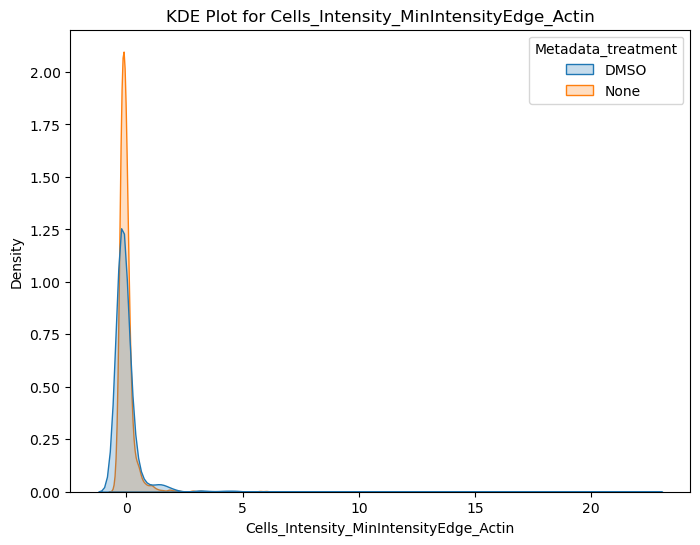

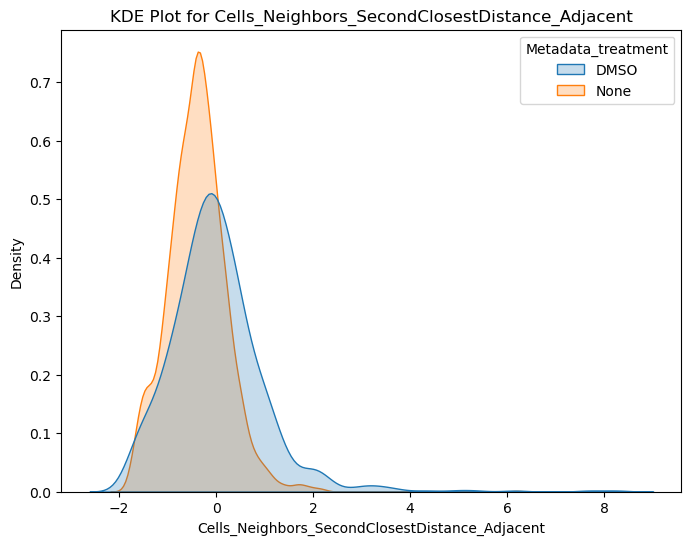

In [13]:
# Filter the plate_4_df DataFrame to include only rows with Metadata_heart_number 7
filtered_plate_df = plate4_df[plate4_df["Metadata_heart_number"] == 7]

# Generate KDE plots for each feature in selected_features with hue based on Metadata_treatment
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.kdeplot(data=filtered_plate_df, x=feature, hue="Metadata_treatment", fill=True, common_norm=False)
    plt.title(f"KDE Plot for {feature}")
    plt.show()

### Look at the cell counts across treatments

In [14]:
# Count the number of cells for each Metadata_treatment
treatment_counts = filtered_plate_df['Metadata_treatment'].value_counts()

# Print the counts
print(treatment_counts)

Metadata_treatment
None    2819
DMSO     939
Name: count, dtype: int64


## Look at the CDF (cumulative distribution function) curves to visualize the KS results for top two features

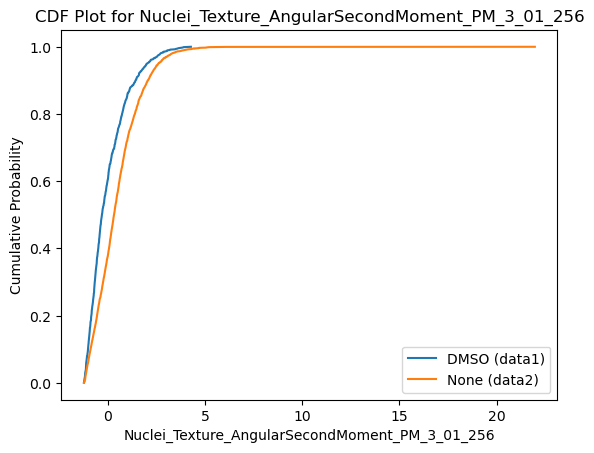

In [15]:
# Extract the specific feature
feature_name = 'Nuclei_Texture_AngularSecondMoment_PM_3_01_256'
data1 = heart_7_DMSO[feature_name]
data2 = heart_7_None[feature_name]

# Sort the data
data1_sorted = np.sort(data1)
data2_sorted = np.sort(data2)

# Calculate the CDFs
cdf_data1 = np.arange(1, len(data1_sorted) + 1) / len(data1_sorted)
cdf_data2 = np.arange(1, len(data2_sorted) + 1) / len(data2_sorted)

# Plot the CDFs
plt.plot(data1_sorted, cdf_data1, label='DMSO (data1)')
plt.plot(data2_sorted, cdf_data2, label='None (data2)')
plt.xlabel('Nuclei_Texture_AngularSecondMoment_PM_3_01_256')
plt.ylabel('Cumulative Probability')
plt.title('CDF Plot for Nuclei_Texture_AngularSecondMoment_PM_3_01_256')
plt.legend()
plt.show()

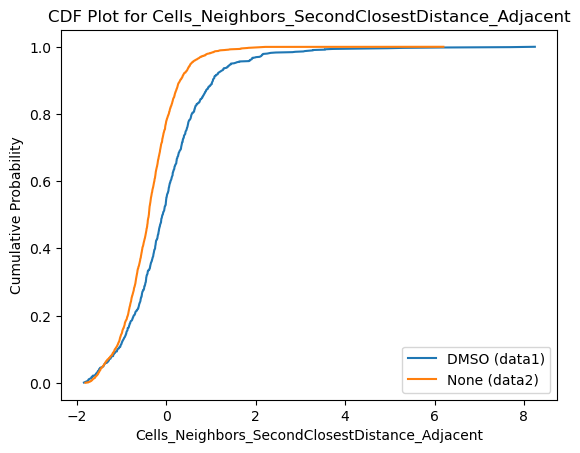

In [16]:
# Assuming heart_7_DMSO and heart_7_None are your datasets containing the feature
# Extract the specific feature
feature_name = 'Cells_Neighbors_SecondClosestDistance_Adjacent'
data1 = heart_7_DMSO[feature_name]
data2 = heart_7_None[feature_name]

# Sort the data
data1_sorted = np.sort(data1)
data2_sorted = np.sort(data2)

# Calculate the CDFs
cdf_data1 = np.arange(1, len(data1_sorted) + 1) / len(data1_sorted)
cdf_data2 = np.arange(1, len(data2_sorted) + 1) / len(data2_sorted)

# Plot the CDFs
plt.plot(data1_sorted, cdf_data1, label='DMSO (data1)')
plt.plot(data2_sorted, cdf_data2, label='None (data2)')
plt.xlabel('Cells_Neighbors_SecondClosestDistance_Adjacent')
plt.ylabel('Cumulative Probability')
plt.title('CDF Plot for Cells_Neighbors_SecondClosestDistance_Adjacent')
plt.legend()
plt.show()